In [4]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import re
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1

# To disable warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(False)

# Visualization settings
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

# Pandas Settings
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 200)

2025-10-15 19:36:17.960467: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 19:36:18.027763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read the Dataset and Overview

In [15]:
import kagglehub

path = kagglehub.dataset_download("parisrohan/credit-score-classification")
df = pd.read_csv(os.path.join(path, "train.csv"))

In [16]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.000,_,809.98,26.823,22 Years and 1 Months,No,49.575,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.000,Good,809.98,31.945,NaN,No,49.575,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.000,Good,809.98,28.609,22 Years and 3 Months,No,49.575,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.000,Good,809.98,31.378,22 Years and 4 Months,No,49.575,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.000,Good,809.98,24.797,22 Years and 5 Months,No,49.575,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.000,4194.171,3183.686,303.645,1625.568,3093.745,5957.448,15204.633
Num_Bank_Accounts,100000.000,17.091,117.405,-1.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,100000.000,22.474,129.057,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,100000.000,72.466,466.423,1.000,8.000,13.000,20.000,5797.000
Delay_from_due_date,100000.000,21.069,14.860,-5.000,10.000,18.000,28.000,67.000
Num_Credit_Inquiries,98035.000,27.754,193.177,0.000,3.000,6.000,9.000,2597.000
Credit_Utilization_Ratio,100000.000,32.285,5.117,20.000,28.053,32.306,36.497,50.000
Total_EMI_per_month,100000.000,1403.118,8306.041,0.000,30.307,69.249,161.224,82331.000


In [19]:
df.describe(include="object").T

,count,unique,top,freq
ID,100000,100000,0x25fb6,1
Customer_ID,100000,12500,CUS_0x942c,8
Month,100000,8,January,12500
Name,90015,10139,Langep,44
Age,100000,1788,38,2833
SSN,100000,12501,#F%$D@*&8,5572
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,20867.67,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408


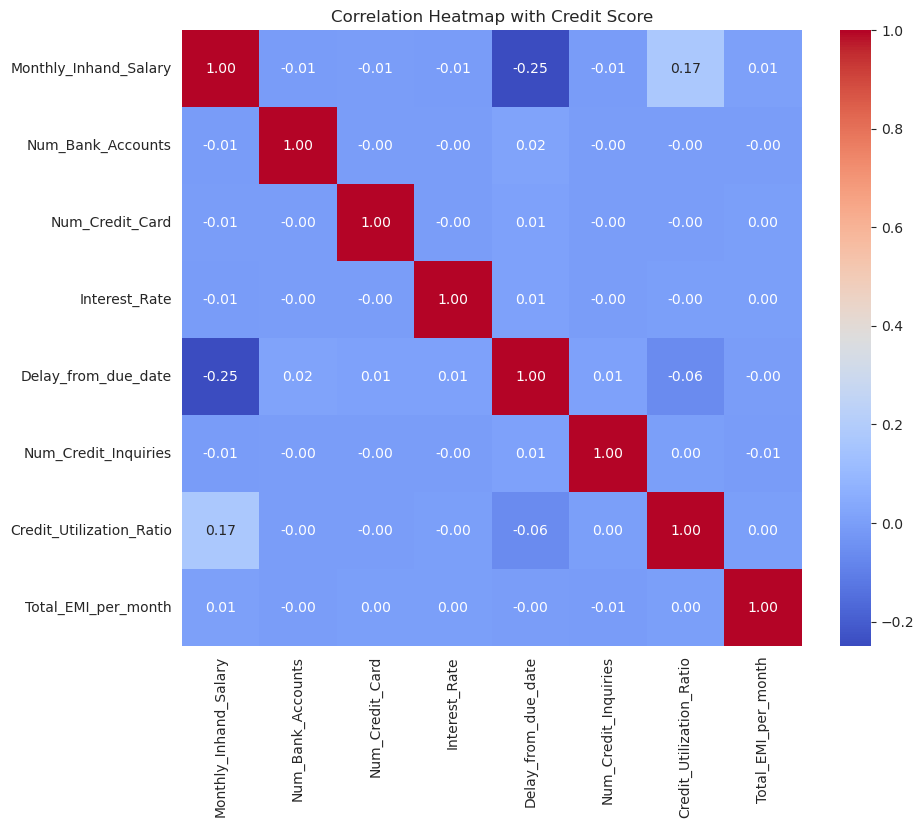

In [20]:
numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(10, 8))

correlation_matrix = numeric_df.corr()

#Plotting
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Correlation Heatmap with Credit Score")
plt.show()

In [21]:
# Numeric columns in the DataFrame
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

ValueError: Could not interpret value `credit_score` for `x`. An entry with this name does not appear in `data`.

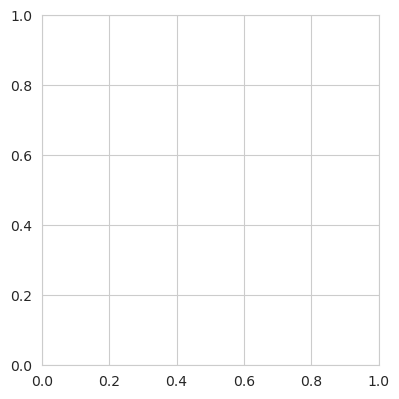

In [22]:

# Calculate number of rows and columns
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

# Plotting
for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x='credit_score', y=col, data=df, palette='Set3')
    plt.title(f'Boxplot of {col} by Credit Score', fontsize=13, pad=10)
    plt.xlabel('Credit Score', fontsize=13)
    plt.ylabel(col, fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Automatically adjust y-axis limits
    plt.ylim(df[col].min() - (df[col].max() - df[col].min()) * 0.1,
             df[col].max() + (df[col].max() - df[col].min()) * 0.1)

# Adjust horizontal (wspace) and vertical (hspace) spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Get all numerical features
features = numeric_columns[:-1]

# Define the layout for the plots
n_cols = 1  # Specify the number of columns here
n_rows = len(features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5))
plt.subplots_adjust(hspace=0.5)

# Plotting
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i])  # hue parametresi kaldırıldı
    axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


NameError: name 'numeric_columns' is not defined

In [23]:
# Function to detect outliers
def detect_outliers_iqr(df):
    outliers = {}

    # Select only numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    for column in numeric_df.columns:
        # Calculate the first (Q1) and third quartiles (Q3)
        Q1 = numeric_df[column].quantile(0.25)
        Q3 = numeric_df[column].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1

        # Determine the lower and upper bounds
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Identify outliers
        outlier_mask = (numeric_df[column] < lower_bound) | (numeric_df[column] > upper_bound)
        outliers[column] = numeric_df[column][outlier_mask]

    return outliers

# Detect outliers
outlier_results = detect_outliers_iqr(df)

# Print the results
for column, outlier_values in outlier_results.items():
    if not outlier_values.empty:
        print(f"{column} outliers:")
        print(outlier_values)
    else:
        print(f"For {column} no outliers.")


For Monthly_Inhand_Salary no outliers.
Num_Bank_Accounts outliers:
267      1414
288      1231
310        67
339       572
356      1488
         ... 
99591     813
99638    1481
99666     474
99722     697
99916     182
Name: Num_Bank_Accounts, Length: 1314, dtype: int64
Num_Credit_Card outliers:
10       1385
40       1288
157      1029
163       488
207      1381
         ... 
99611     514
99615     232
99619    1430
99769     679
99811     158
Name: Num_Credit_Card, Length: 2266, dtype: int64
Interest_Rate outliers:
44       5318
89        433
167      5240
178      4975
229       668
         ... 
99791    4396
99801     387
99882    1947
99914     360
99997    5729
Name: Interest_Rate, Length: 2034, dtype: int64
For Delay_from_due_date no outliers.
Num_Credit_Inquiries outliers:
173     1050.000
193     1044.000
198     1936.000
234      568.000
312     1618.000
          ...   
99717   1361.000
99769    310.000
99789     93.000
99800   2209.000
99872     74.000
Name: Num_Credit

In [24]:
df["credit_score"].value_counts(normalize = True) # 2:Good, 1: Standard, 0: Poor

KeyError: 'credit_score'

# Data Preprocessing


In [ ]:
# List of unique loan values
unique_loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
                     'No Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']

# Adding a new column for each unique loan type and checking how many times it appears
for loan_type in unique_loan_types:
    # Replacing '-' and spaces with underscores, converting other characters to lowercase
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()

    # Counting how many times the loan_type value appears in each row
    df[cleaned_loan_type] = df['type_of_loan'].apply(lambda x: x.count(loan_type))


NameError: name 'df' is not defined

In [25]:
df = df.drop([
    "id", "customer_id", "name", "ssn", "type_of_loan"], axis=1)

df.head()

KeyError: "['id', 'customer_id', 'name', 'ssn', 'type_of_loan'] not found in axis"

In [ ]:
payment_mapping = {
    'High_spent_Large_value_payments': 6,#Successfully managing large debts provides the most positive contribution to the credit score.
    'High_spent_Medium_value_payments': 5, #Medium-value payments with high spending positively impact the credit score.
    'High_spent_Small_value_payments': 4, #Small payments can negatively affect the credit score if debts accumulate over time.
    'Low_spent_Large_value_payments': 3, #shows quick financial responsibility, positively affecting the credit score.
    'Low_spent_Medium_value_payments': 2, #contributes positively to the credit score by demonstrating debt management.
    'Low_spent_Small_value_payments': 1 #may limit the credit history and provide minimal contribution to the credit score
}


df['payment_behaviour'] = df['payment_behaviour'].map(payment_mapping)

df['payment_behaviour'] = pd.to_numeric(df['payment_behaviour'], downcast='integer')


NameError: name 'df' is not defined

In [26]:
# Convert the credit_mix column to numerical values
df['credit_mix'] = df['credit_mix'].map({'Good': 2, 'Standard': 1, 'Bad': 0})

df['credit_mix'] = pd.to_numeric(df['credit_mix'], downcast='integer')

KeyError: 'credit_mix'

In [27]:
# Convert the payment_of_min_amount column to numerical values
df['payment_of_min_amount'] = df['payment_of_min_amount'].map({'Yes': 1, 'No': 0})

df['payment_of_min_amount'] = pd.to_numeric(df['payment_of_min_amount'], downcast='integer')



KeyError: 'payment_of_min_amount'

In [28]:
df = pd.get_dummies(df, columns=['occupation'])

KeyError: "None of [Index(['occupation'], dtype='object')] are in the [columns]"

In [29]:
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

#Mapping
df['month'] = df['month'].map(month_map)

df['month'] = pd.to_numeric(df['month'], downcast='integer')

KeyError: 'month'

In [30]:
# Separate features and target variable
X = df.drop("credit_score", axis=1)
y = df.credit_score

KeyError: "['credit_score'] not found in axis"

In [31]:
y.value_counts(normalize=True) # unbalanced data  2:Good, 1: Standard, 0: Poor

NameError: name 'y' is not defined

In [32]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.000,_,809.98,26.823,22 Years and 1 Months,No,49.575,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.000,Good,809.98,31.945,NaN,No,49.575,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.000,Good,809.98,28.609,22 Years and 3 Months,No,49.575,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.000,Good,809.98,31.378,22 Years and 4 Months,No,49.575,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.000,Good,809.98,24.797,22 Years and 5 Months,No,49.575,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Train-Test Splits

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,
                                                    stratify=y, random_state=42)

NameError: name 'X' is not defined

In [34]:
# Columns to apply RobustScaler
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance', "annual_income", "monthly_inhand_salary"]

# Columns to apply StandardScaler (All columns except robust columns)
standard_columns = [col for col in X_train.columns if col not in robust_columns]

# Create the ColumnTransformer
scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)])

# Apply to training data
X_train_scaled= scaler.fit_transform(X_train)

# Apply to test data
X_test_scaled = scaler.transform(X_test)


NameError: name 'X_train' is not defined

In [35]:
y_train = np.array(y_train)
y_test = np.array(y_test)


NameError: name 'y_train' is not defined

In [36]:
pd.Series(y_train).value_counts()

NameError: name 'y_train' is not defined

In [37]:
# SMOTE causes overfitting in this data and model architecture.That's way I don't use
#smote = SMOTE(random_state=42)
#X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [38]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# ANN Model

In [39]:
# Compute class_weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in zip(np.unique(y_train), class_weights_array)}

NameError: name 'y_train' is not defined

In [40]:
tf.random.set_seed(42)

# Model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu',),
    BatchNormalization(),
    Dropout(0.35),
    
    Dense(512, activation='relu', kernel_regularizer=l1(1e-4)),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(3, activation='softmax')
])

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.0003),  # Reduced learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping with patience and best weight restoration
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=35,
                               restore_best_weights=True)

# Model training
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    validation_data=(X_test_scaled, y_test),
                    batch_size=1024,
                    epochs=500,
                    verbose=1,
                    callbacks=[early_stopping], class_weight=class_weights)


NameError: name 'X_train' is not defined

Since the fitting process finalized at epoch 295, I will train the final model for 260 epochs without using early stopping.

In [41]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

NameError: name 'model' is not defined

In [42]:
model.evaluate(X_test_scaled, y_test)

NameError: name 'model' is not defined

In [43]:
model.evaluate(X_train_scaled, y_train)

NameError: name 'model' is not defined

In [44]:
eval_metric(model, X_train_scaled, y_train, X_test_scaled, y_test)

NameError: name 'model' is not defined

In [45]:
model.summary()

NameError: name 'model' is not defined

# Final Model

In [46]:
print(X.shape)
print(y.shape)

NameError: name 'X' is not defined

In [47]:
# Columns to apply RobustScaler
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance', "annual_income", "monthly_inhand_salary"]
# Columns to apply StandardScaler (All columns except robust columns)
standard_columns = [col for col in X_train.columns if col not in robust_columns]

# Create the ColumnTransformer
scaler= ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)
    ]
)

scaler = scaler.fit(X)



NameError: name 'X_train' is not defined

In [48]:
pickle.dump(scaler, open("credit_score_scaler", 'wb'))

NameError: name 'scaler' is not defined

In [49]:
X_scaled = scaler.transform(X)

NameError: name 'scaler' is not defined

In [50]:
tf.random.set_seed(42)

# Model architecture
final_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu',),
    BatchNormalization(),
    Dropout(0.35),
    
    Dense(512, activation='relu', kernel_regularizer=l1(1e-4)),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(3, activation='softmax')
])

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.0003), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Model training
history = model.fit(x=X_scaled,
                    y=y,
                    batch_size=1024,
                    epochs=260,
                    verbose=1,
                    class_weight=class_weights)


NameError: name 'X_train' is not defined

In [51]:
# Save Model

save_model(final_model, 'final_model_credit_score.keras')

NameError: name 'final_model' is not defined

# Final Model Prediction

In [ ]:
scaler = pickle.load(open("credit_score_scaler", "rb"))

In [ ]:
final_model = load_model('final_model_credit_score.keras')

In [ ]:
# Generating random data suitable for statistics using your sample dataset
def generate_synthetic_data(df, num_samples=50):
    synthetic_data = pd.DataFrame()

    for column in df.columns:
        if column != 'credit_score':  # Excluding the target column (e.g., for classification)
            # Extract statistics from your current dataset
            min_val = df[column].min()
            max_val = df[column].max()
            mean_val = df[column].mean()
            std_val = df[column].std()

            # Generate random data suitable for statistics
            synthetic_data[column] = np.random.normal(loc=mean_val, scale=std_val, size=num_samples)

            # Adjust the minimum and maximum values of the generated data to match the original dataset
            synthetic_data[column] = synthetic_data[column].clip(lower=min_val, upper=max_val)

    return synthetic_data

# Generating 50 rows of synthetic data based on the statistics of your current dataset
df_prediction = generate_synthetic_data(df, num_samples=50)


In [ ]:
df_prediction_scaled = scaler.transform(df_prediction)

In [ ]:
final_model.predict(df_prediction_scaled)

In [ ]:
y_pred_probabilities = final_model.predict(df_prediction_scaled)

y_pred = y_pred_probabilities.argmax(axis=1) #prediction values



In [ ]:
normalized_predictions = tf.nn.softmax(y_pred_probabilities, axis=-1).numpy()#normalized probabilites of each class

In [ ]:
pred_df = pd.DataFrame({'pred': y_pred})

# Mapping dictionary for the reverse transformation
mapping = {2: 'Good', 1: 'Standard', 0: 'Poor'}

# Apply the mapping
pred_df["pred"] = pred_df["pred"] .map(mapping)



In [ ]:
pred_df["pred_proba_poor"] = normalized_predictions[:,0]
pred_df["pred_proba_standard"] = normalized_predictions[:,1]
pred_df["pred_proba_good"] = normalized_predictions[:,2]
pred_df

In [ ]:
#If you've reviewed everything up to this point, I guess I did a good job. Your feedback is valuable.
#Also, the upvote button is in the top right corner :)